In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable 
from tqdm import trange

ModuleNotFoundError: No module named 'torch'

In [2]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year

# train_data = data[["year", "month", "day", "hour", "Departure lat", "Departure long"]]
features_departure = ["month", "day", "hour", "Departure lat", "Departure long"]
counts_data = data.groupby(["month", "day", "hour", "Departure lat", "Departure long", "Departure station"]).size().reset_index(name='counts')

device = torch.device("cuda")




Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [3]:
stations = data[["Departure lat", "Departure long", "Departure station"]].drop_duplicates()
max_lat, min_lat = stations["Departure lat"].max(), stations["Departure lat"].min()
max_long, min_long = stations["Departure long"].max(), stations["Departure long"].min()
batch = stations.shape[0]
print(batch)
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": []})
for row in stations.iterrows():
    time = pd.date_range('2020-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["Departure lat"] = (row[1]["Departure lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["Departure long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["Departure station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])

train_data = predict_data_departure.merge(counts_data[["month", "day", "hour", "Departure station", "counts"]], how="left", left_on=["month", "day", "hour", "Departure station"], right_on=["month", "day", "hour", "Departure station"])
train_data["counts"] = train_data["counts"].fillna(0)
train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
# train_data = train_data.sort_values(by="Departure station")
print(train_data)
x = train_data[features_departure]
y = train_data["counts"]

221
            month       day      hour  Departure lat  Departure long  \
0        0.083333  0.032258  0.000000       0.693601        0.000627   
1        0.083333  0.032258  0.043478       0.693601        0.000627   
2        0.083333  0.032258  0.086957       0.693601        0.000627   
3        0.083333  0.032258  0.130435       0.693601        0.000627   
4        0.083333  0.032258  0.173913       0.693601        0.000627   
...           ...       ...       ...            ...             ...   
1935955  1.000000  0.967742  0.826087       0.284948        0.841722   
1935956  1.000000  0.967742  0.869565       0.284948        0.841722   
1935957  1.000000  0.967742  0.913043       0.284948        0.841722   
1935958  1.000000  0.967742  0.956522       0.284948        0.841722   
1935959  1.000000  0.967742  1.000000       0.284948        0.841722   

                                Departure station  counts  
0        0099 Vancouver Art Gallery - North Plaza     1.0  
1        00

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=20, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions

In [5]:
train_x = torch.tensor(x.to_numpy()).float()
train_y = torch.tensor(y.to_numpy()).float()
l = train_x.shape[0]
train_x = train_x.reshape((batch, int(l / batch), 5))
train_y = train_y.reshape((batch, int(l / batch), 1))

model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for e in range(20):
    total_loss = 0
    for b in trange(batch):
        inputs = train_x[b:b+1, :, :].to(device)
        outputs = train_y[b:b+1, :].to(device)
        model.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device), torch.zeros(1, 1, model.hidden_layer_size).to(device))
        out = model(inputs)
        loss = criterion(out, outputs)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        # print("one_step")
    print('Loss:',total_loss / batch)

100%|██████████| 221/221 [01:43<00:00,  2.13it/s]


Loss: 0.764691403843631


100%|██████████| 221/221 [01:35<00:00,  2.31it/s]


Loss: 0.7287306280973119


100%|██████████| 221/221 [01:35<00:00,  2.32it/s]


Loss: 0.7090108825854654


100%|██████████| 221/221 [01:35<00:00,  2.32it/s]


Loss: 0.7034600599504569


100%|██████████| 221/221 [01:31<00:00,  2.41it/s]


Loss: 0.7031765959196096


100%|██████████| 221/221 [01:35<00:00,  2.32it/s]


Loss: 0.7028346174097372


100%|██████████| 221/221 [01:38<00:00,  2.24it/s]


Loss: 0.703387740535906


100%|██████████| 221/221 [01:36<00:00,  2.28it/s]


Loss: 0.7029192865914686


100%|██████████| 221/221 [01:33<00:00,  2.37it/s]


Loss: 0.7036798009101082


100%|██████████| 221/221 [01:32<00:00,  2.39it/s]


Loss: 0.7024271916977354


100%|██████████| 221/221 [01:38<00:00,  2.24it/s]


Loss: 0.7042933950006827


100%|██████████| 221/221 [01:35<00:00,  2.31it/s]


Loss: 0.7025699387072708


100%|██████████| 221/221 [01:33<00:00,  2.36it/s]


Loss: 0.7035756583970326


100%|██████████| 221/221 [01:35<00:00,  2.32it/s]


Loss: 0.7024996919658592


100%|██████████| 221/221 [01:31<00:00,  2.42it/s]


Loss: 0.7031211992894295


100%|██████████| 221/221 [01:42<00:00,  2.15it/s]


Loss: 0.7020991712479907


100%|██████████| 221/221 [01:38<00:00,  2.24it/s]


Loss: 0.7026675720593778


100%|██████████| 221/221 [01:35<00:00,  2.30it/s]


Loss: 0.7013670770110082


100%|██████████| 221/221 [01:38<00:00,  2.23it/s]


Loss: 0.7020356514748203


100%|██████████| 221/221 [01:38<00:00,  2.24it/s]

Loss: 0.6959114628854498


<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

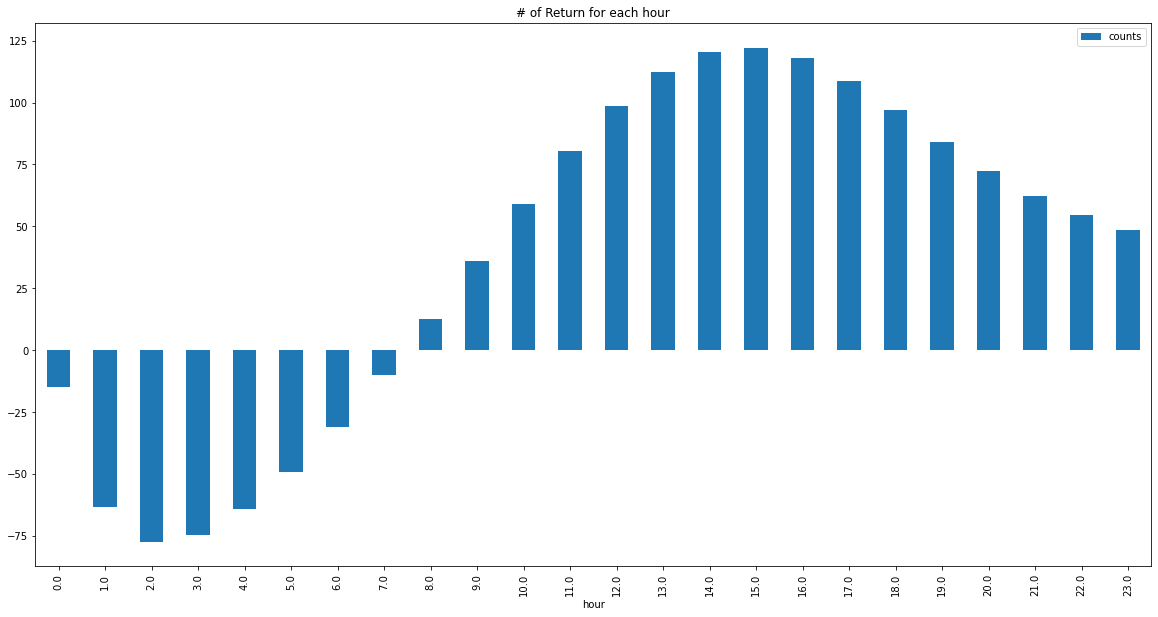

In [21]:
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": [],})
period = 168
for row in stations.iterrows():
    time = pd.date_range('2022-04-01', periods=period, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour / 23
    station_data["day"] = station_data["time"].dt.day / 31
    station_data["month"] = station_data["time"].dt.month / 12
    station_data["Departure lat"] = (row[1]["Departure lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["Departure long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["Departure station"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])
predict_x = predict_data_departure[features_departure].to_numpy()
tensor_x = torch.tensor(predict_x).float()
tensor_x = tensor_x.reshape((batch, int(tensor_x.shape[0] / batch), 5))
outs = np.zeros((batch, period))
with torch.no_grad():
    for b in range(batch):
        input = tensor_x[b:b+1, :, :].to(device)
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device), torch.zeros(1, 1, model.hidden_layer_size).to(device))
        output = model(input)
        outs[b, :] = torch.flatten(output).cpu()
# print(output)
predict_data_departure["counts"] = outs.flatten()
predict_data_departure["hour"] = (predict_data_departure["hour"] * 23).round()
predict_data_departure = predict_data_departure[["hour", "counts"]].groupby("hour").sum()
# print(predict_data_departure)
predict_data_departure.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")
# predict_data_departure = predict_data_departure[["Departure station", "counts"]].groupby("Departure station").sum().sort_values("counts")
# print(predict_data_departure)
# test = counts_data[["Departure station", "counts"]].groupby("Departure station").sum().sort_values("counts")
# print(test)